In [ ]:
# Discard the output of this cell.
%%capture

!apt-get install unrar
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar
!unrar x UCF50.rar
!rm -fr UCF50.rar
!pip install av

In [ ]:
import torch
import cv2
import torch
from glob import glob
import matplotlib.pyplot as plt
import torch
import numpy as np

Reproducibility

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

## Video preprocessing

In [2]:
def get_frames(pathname: str) -> torch.Tensor:
    cap = cv2.VideoCapture(pathname)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        fixed_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(torch.tensor(fixed_frame, dtype=torch.int64))
    return torch.stack(frames, dim=0)

In [3]:
PATH_DATASET_DIR = "/kaggle/working/UCF50"
HEIGHT, WIDTH = 240, 320
SEQUENCE_LENGTH = 20

videos = glob(f"{PATH_DATASET_DIR}/**/*.avi")
labels = [path.replace(f"{PATH_DATASET_DIR}/", "") for path in glob(f"{PATH_DATASET_DIR}/**")]


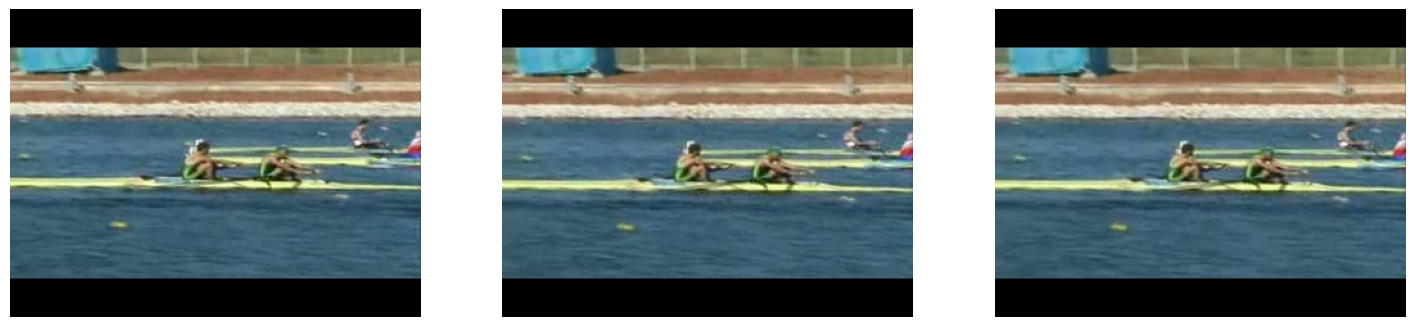

In [4]:
frames = get_frames(videos[0])

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, frame in enumerate(frames[10:13]):
    axes[i].imshow(frame)
    axes[i].axis("off")

plt.show()

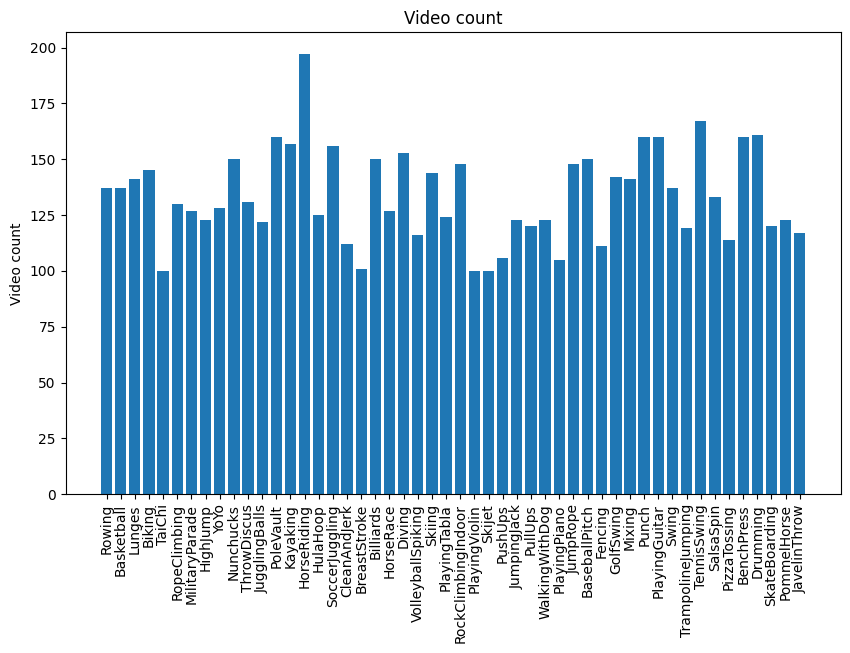

In [5]:
data = dict()
for video in videos:
    label = video.split("/")[-2]
    
    if label in data:
        data[label] += 1
    else:
        data[label] = 1

fig, ax = plt.subplots(figsize=(10,6))

ax.bar(data.keys(), data.values())

ax.set_ylabel('Video count')
ax.set_title('Video count')
plt.xticks(rotation=90)
plt.show()

We can see that dataset is imbalanced itself. Some of the videos are more popular, others are more rare.

In [6]:
min(data, key=lambda x: data[x]), max(data, key=lambda x: data[x])

('TaiChi', 'HorseRiding')

In [7]:
data['PlayingViolin'], data["HorseRiding"]

(100, 197)

Custom Dataset class that can handle balanced frame datasets

In [ ]:
from torch.utils.data import Dataset

class VideoDataset(Dataset):

    def __init__(self, all_video_paths, transform=None, num_videos=None):
        self.all_video_paths = all_video_paths
        self.transform = transform
        self.lab2idx = {}

        if num_videos is not None:  # if we need to balance dataset
            labels = set([path.split("/")[-2] for path in all_video_paths])
            self.lab2idx = {w: i for i, w in enumerate(labels)}
            buffer = []
            for label in labels:
                videos = []
                for path in all_video_paths:
                    if label in path:
                        videos.append(path)
                videos = np.random.choice(videos, num_videos)
                buffer.extend(videos)
            self.video_paths = buffer

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):

        video_path = self.video_paths[idx]
        label = video_path.split("/")[-2]
        frames = self.read_video(video_path)

        if self.transform:
            frames = torch.stack([self.transform(frame) for frame in frames])
        else:
            frames = torch.stack(frames)

        return frames, self.lab2idx[label]

    def read_video(self, video_path):

        cap = cv2.VideoCapture(video_path)
        frames = []
        frames_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # number of frames of the video
        window = max(int(frames_count/SEQUENCE_LENGTH), 1)  # timestep between frames

        for i in range(SEQUENCE_LENGTH):
            cap.set(cv2.CAP_PROP_POS_FRAMES, i * window)  # set timestemp
            ret, frame = cap.read()
            if not ret: # if frame is read correctly ret is True
                break
            fixed_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(fixed_frame)

        cap.release()
        return np.array(frames)
    
    

In [9]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((240, 240)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [10]:
dataset = VideoDataset(videos, transform, 100)

In [11]:
from torch.utils.data import random_split

train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [20]:
torch.save(train_dataset, 'train.pt')
torch.save(val_dataset, 'val.pt')
torch.save(test_dataset, 'test.pt')